In [138]:
from misc import * 
P = lambda x: torch.log(torch.exp(Uniform(torch.tensor([-3.]).to(x.device),torch.tensor([2.]).to(x.device)).log_prob(x)) + torch.rand(x.shape[0]).to(x.device)*0.000001)
Q = lambda x: torch.log(torch.exp(Uniform(torch.tensor([-6.]).to(x.device),torch.tensor([4.]).to(x.device)).log_prob(x)) + torch.rand(x.shape[0]).to(x.device)*0.000001)
Q_samples = Uniform(torch.tensor([-6.]),torch.tensor([4.])).sample([1000])

In [208]:
import torch
from tqdm import tqdm

class ClassifierFromDensity(torch.nn.Module):
    def __init__(self,samples_0, log_prob_1, hidden_dims = []):
        super().__init__()
        self.samples0 = samples_0
        self.log_prob_1 = log_prob_1
        network_dimensions = [self.samples0.shape[-1]] + hidden_dims + [1]
        network = []
        for h0, h1 in zip(network_dimensions, network_dimensions[1:]):
            network.extend([torch.nn.Linear(h0, h1), torch.nn.SiLU(), ])
        self.f = torch.nn.Sequential(*network)
        self.w = torch.distributions.Dirichlet(torch.ones(self.samples0.shape[0])).sample()

    def log_prob(self, x):
        f = self.f(x)
        log_prob = self.log_prob_1(x).unsqueeze(-1)
        return torch.log(torch.softmax(torch.cat([f,log_prob], dim = -1), dim = -1))

    def loss(self, x, w):
        return torch.sum(w * (self.log_prob(x)[:,0]))

    def train(self, epochs, batch_size=None, lr=5e-3, weight_decay=5e-6, verbose = False):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        if batch_size is None:
            batch_size = self.samples0.shape[0]
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        dataset = torch.utils.data.TensorDataset(self.samples0.to(device), self.w.to(device))

        if verbose:
            pbar = tqdm(range(epochs))
        else:
            pbar = range(epochs)
        for t in pbar:
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for batch in dataloader:
                optimizer.zero_grad()
                batch_loss = self.loss(batch[0], batch[1])
                batch_loss.backward()
                optimizer.step()
            if verbose:
                with torch.no_grad():
                    iteration_loss = torch.tensor([self.loss(batch[0], batch[1]) for batch in dataloader]).mean().item()
                pbar.set_postfix_str('loss = ' + str(round(iteration_loss, 6)) + '; device = ' + str(device))
        self.to(torch.device('cpu'))

In [209]:
classif = ClassifierFromDensity(Q_samples, P, [32,32])
classif.train(200, verbose = True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 46.44it/s, loss = -0.11547; device = cuda]


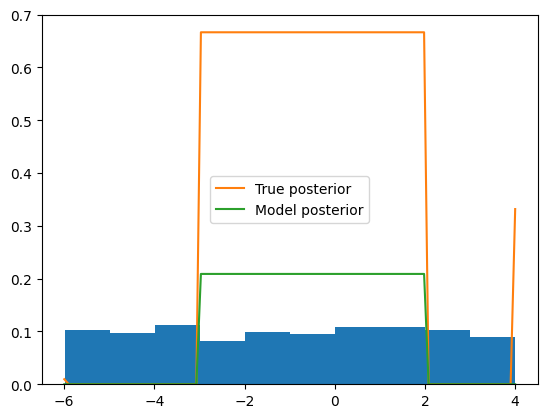

In [210]:
import matplotlib.pyplot as plt
tt = torch.linspace(-6,4,100)
posterior = lambda x: torch.exp(P(x))/(torch.exp(P(x))+ torch.exp(Q(x)))
plt.hist(Q_samples.numpy(), density = True)
plt.plot(tt, posterior(tt.unsqueeze(-1)), label = 'True posterior')
with torch.no_grad():
    plt.plot(tt,torch.exp(classif.log_prob(tt.unsqueeze(-1))[:,1]) , label = 'Model posterior')
plt.legend()

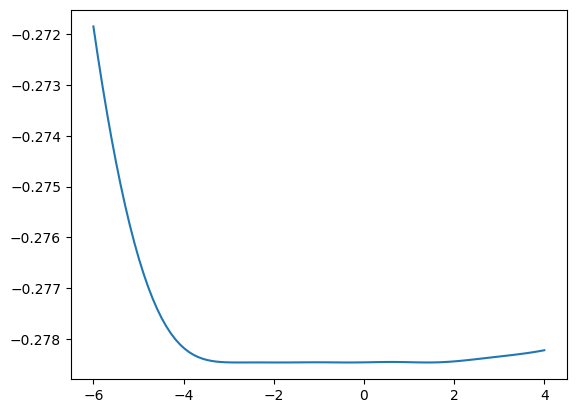

In [207]:
with torch.no_grad():
    ratio = lambda x: torch.exp(P(x) - Q(x))
    plt.plot(tt, classif.f(tt.unsqueeze(-1)))